In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as display

import PIL.Image
import functools
import time

from numpy.random import seed
seed(111)

mpl.rcParams['figure.figsize'] = (15,15)
mpl.rcParams['axes.grid'] = False

def to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

content_path = 'columbia.jpg'
style_path = 'van_Gogh.jpg'

def load_img(path):

  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  l = max(shape)
  scale = 512 / l

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def show_image(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

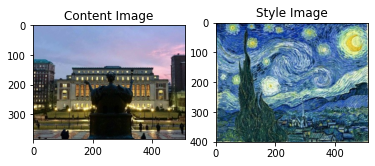

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
show_image(content_image, 'Content Image')

plt.subplot(1, 2, 2)
show_image(style_image, 'Style Image')

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

574717952/574710816 [==============================] - 4s 0us/step


In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
def vgg_layers(layers):
  # load the pre-trained vgg 
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  output = [vgg.get_layer(name).output for name in layers]

  model = tf.keras.Model([vgg.input], output)
  return model

In [ ]:
def gram_matrix(x):
  shape = tf.shape(x)
  out1 = tf.linalg.einsum('bijc,bijd->bcd', x, x)
  z = tf.cast(shape[1]*shape[2], tf.float32)
  return out1/z

In [ ]:
class NeuralTransfer(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(NeuralTransfer, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False
    self.content_layers = content_layers
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)

  def call(self, img):
    "Expects float input in [0,1]"
    img = img*255.0
    img_pre = tf.keras.applications.vgg19.preprocess_input(img)
    img1 = self.vgg(img_pre)

    style = img1[:self.num_style_layers]
    style = [gram_matrix(s) for s in style]

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style)}

    content = img1[self.num_style_layers:]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content)}


    return {'style':style_dict,'content':content_dict}

In [ ]:
import numpy as np
img = np.zeros([100,100,3],dtype=np.uint8)
img.fill(255)

In [ ]:
# the layers to extract the content
content_layers = ['block4_conv2'] 

# the layers to extract the style
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [ ]:
basic_image = load_img("white.jpg")

In [ ]:
extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(basic_image))

style_results = results['style']

In [ ]:
content_y = extractor(basic_image)['content']
style_y = extractor(style_image)['style']

In [ ]:
image = tf.Variable(basic_image)

In [ ]:
def image_clip(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1
content_weight=1e-3

In [ ]:
def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss

In [ ]:
def train_iter(image):
  with tf.GradientTape() as tape:
    x = extractor(image)
    loss = compute_loss(x)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(image_clip(image))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

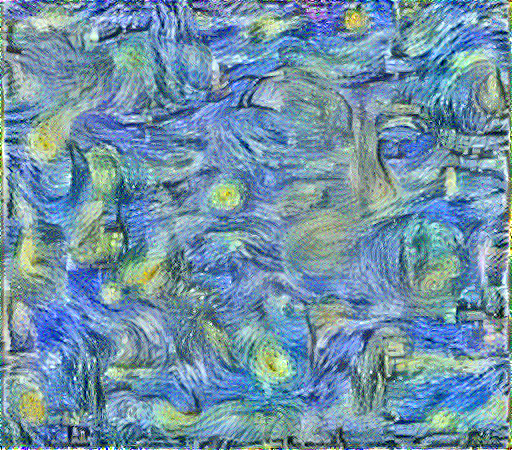

'style_1000_5.png'

train step: 1000
Total time: 141.2


In [ ]:
import time
import os

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("style_%s_5.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

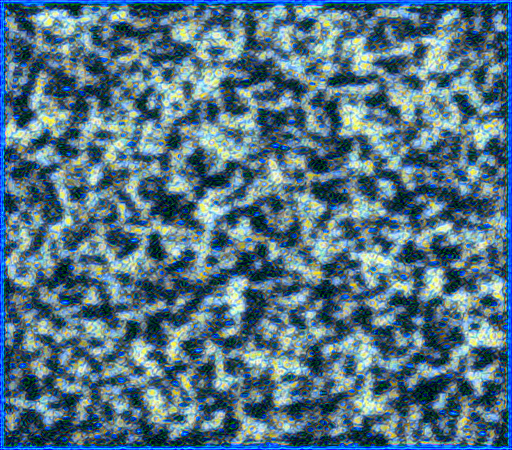

'style_1000_1.png'

train step: 1000
Total time: 108.9


In [ ]:
# block_conv1
style_layers = ['block1_conv1']
extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(basic_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(basic_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss



image = tf.Variable(basic_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("style_%s_1.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

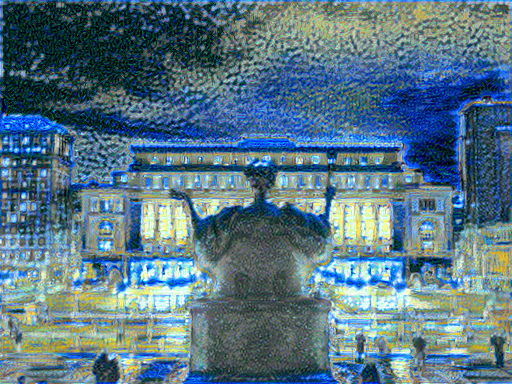

'content_1000_1.png'

train step: 1000
Total time: 93.5


In [ ]:
style_layers = ['block1_conv1']
extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(content_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss



image = tf.Variable(content_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("content_%s_1.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

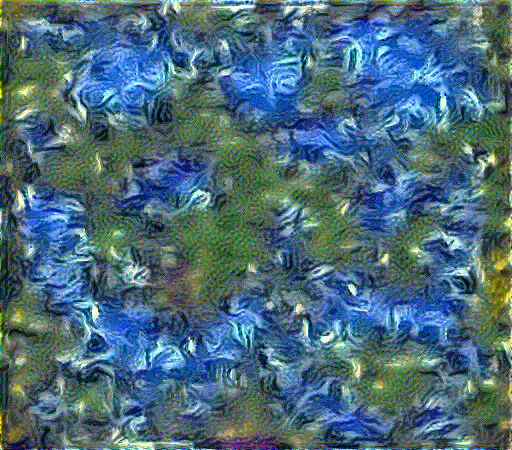

'style_1000_2.png'

train step: 1000
Total time: 112.3


In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(basic_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(basic_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss

image = tf.Variable(basic_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("style_%s_2.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

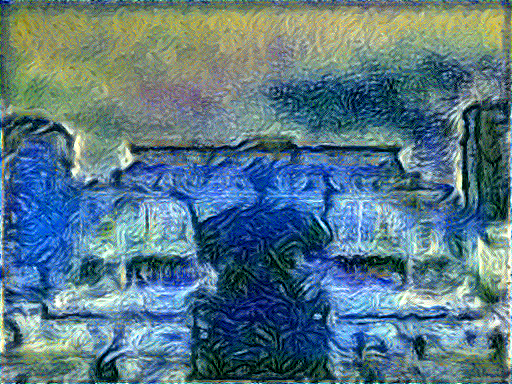

'content_1000_2.png'

train step: 1000
Total time: 96.3


In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1']
extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(content_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss



image = tf.Variable(content_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("content_%s_2.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

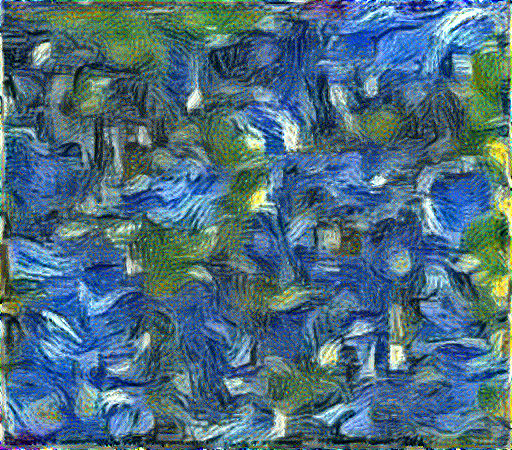

'style_1000_3.png'

train step: 1000
Total time: 115.5


In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(basic_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(basic_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss

image = tf.Variable(basic_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("style_%s_3.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

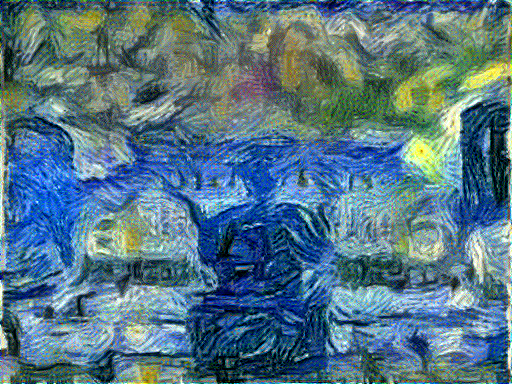

'content_1000_3.png'

train step: 1000
Total time: 99.5


In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1']
extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(content_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss



image = tf.Variable(content_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("content_%s_3.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

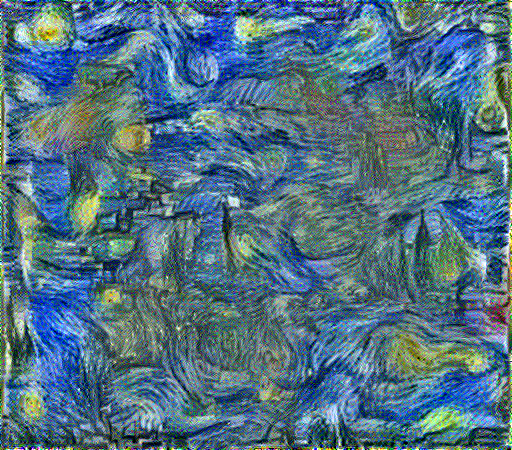

'style_1000_4.png'

train step: 1000
Total time: 118.2


In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(basic_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(basic_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss

image = tf.Variable(basic_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("style_%s_4.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

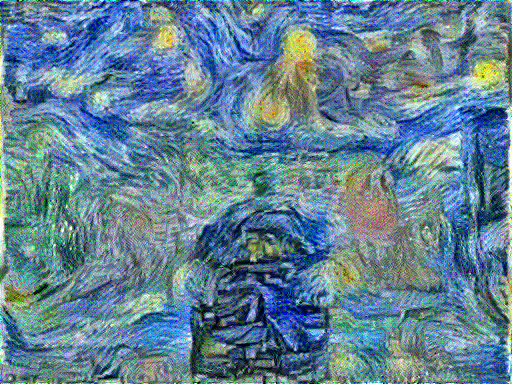

'content_1000_4.png'

train step: 1000
Total time: 101.5


In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1']
extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(content_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss



image = tf.Variable(content_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("content_%s_4.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

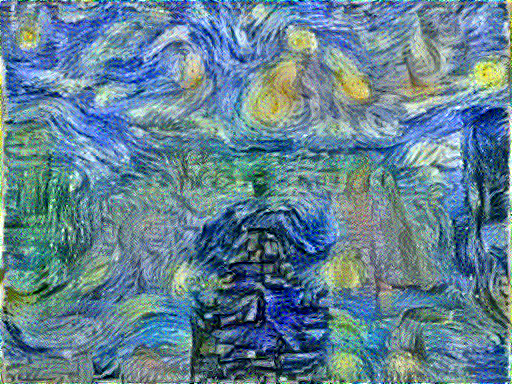

'content_1000_5.png'

train step: 1000
Total time: 121.6


In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

content_y = extractor(content_image)['content']
style_y = extractor(style_image)['style']

def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = content_loss + style_loss
    return loss



image = tf.Variable(content_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("content_%s_5.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))